In [1]:
# todo: plot interest and price over time

In [2]:
# import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import mapclassify

In [ ]:
%matplotlib inline 

In [3]:
# load the data
price_data = pd.read_csv('../../data/raw/Bitcoin Historical Data - 07-18-2010_08-18-2020.csv')
price_data

,Date,Price,Open,High,Low,Vol.,Change %
0,"Aug 18, 2020","12,009.6","12,283.0","12,381.4","11,842.0",652.98K,-2.22%
1,"Aug 17, 2020","12,282.6","11,898.8","12,444.1","11,764.0",628.41K,3.22%
2,"Aug 16, 2020","11,899.0","11,845.5","11,922.5","11,688.9",410.81K,0.45%
3,"Aug 15, 2020","11,845.3","11,751.1","11,964.0","11,711.5",499.10K,0.80%
4,"Aug 14, 2020","11,750.8","11,771.1","11,835.5","11,651.5",435.44K,-0.17%
...,...,...,...,...,...,...,...
3680,"Jul 22, 2010",0.1,0.1,0.1,0.1,2.16K,0.00%
3681,"Jul 21, 2010",0.1,0.1,0.1,0.1,0.58K,0.00%
3682,"Jul 20, 2010",0.1,0.1,0.1,0.1,0.26K,0.00%
3683,"Jul 19, 2010",0.1,0.1,0.1,0.1,0.57K,0.00%


In [4]:
# set index to date and change its format
price_data = price_data.set_index(price_data['Date'])
price_data.index = pd.to_datetime(price_data.index)
price_data.drop('Date', inplace=True, axis=1)

In [87]:
price_data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-08-18,"12,009.6","12,283.0","12,381.4","11,842.0",652.98K,-2.22%
2020-08-17,"12,282.6","11,898.8","12,444.1","11,764.0",628.41K,3.22%
2020-08-16,"11,899.0","11,845.5","11,922.5","11,688.9",410.81K,0.45%
2020-08-15,"11,845.3","11,751.1","11,964.0","11,711.5",499.10K,0.80%
2020-08-14,"11,750.8","11,771.1","11,835.5","11,651.5",435.44K,-0.17%
...,...,...,...,...,...,...
2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%
2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%
2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%


According to google trends documentation they provide not exact number of requests for particular term but interest over time, so the data is relative and not absolute. That's why we need non trivial approach to look correlations between exchange rate and keyword volume trend. Google Trends allows to fetch daily data just per 6 months, so we have snapshots of trends distribution every 6 months.  

In [5]:
def create_data():
    result = []
    file_names = ['bitcoin-2011_1.csv', 'bitcoin-2011_2.csv', 'bitcoin-2012_1.csv', 'bitcoin-2012_2.csv',                                       'bitcoin-2013_1.csv', 'bitcoin-2013_2.csv', 'bitcoin-2014_1.csv', 'bitcoin-2014_2.csv', 'bitcoin-2015_1.csv',                   'bitcoin-2015_2.csv', 'bitcoin-2016_1.csv','bitcoin-2016_2.csv', 'bitcoin-2017_1.csv','bitcoin-2017_2.csv',                    'bitcoin-2018_1.csv', 'bitcoin-2018_2.csv', 'bitcoin-2019_1.csv', 'bitcoin-2019_2.csv',                                          'bitcoin-2020_1.csv']
    base_path = '../../data/raw/'
    for file_name in file_names:
        # load data
        df = pd.read_csv(f'{base_path}{file_name}')
        # update index
        df = df.set_index('date')
        # convert index to date
        df.index = pd.to_datetime(df.index)
        # select price in time range
        price_df = price_data[(price_data.index >= df.index[0]) & (price_data.index <= df.index[-1])]
        # set price by day
        df['price'] = price_df['Price']
        # convert string price to float
        df['price'] = df['price'].str.replace(',', '').astype(float)
        # add dataframe to result
        result.append(df)
    return result



In [6]:
data = create_data()

### Plot data

We will first plot the data to represent interest of population by geo location.

In [69]:
# load world geo data
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)

In [70]:
# load interest ratio by world
interest_by_geo_world = pd.read_csv('../../data/raw/geoMap_world.csv')
interest_by_geo_world.dropna(inplace=True)
interest_by_geo_world = interest_by_geo_world.set_index('country')
interest_by_geo_world['search_volume_ratio'] = interest_by_geo_world['search_volume_ratio'].astype(int)

In [71]:
# clean interest_by_geo_world
merged = pd.merge(left=world, right=interest_by_geo_world, how='left', left_on='name', right_on='country')
interest_by_geo_world = merged['search_volume_ratio']

In [72]:
def plot_by_geo_map(geo, data):
    '''Plots search ratio by geo location'''
    scheme = mapclassify.Quantiles(data, k=100)

    gplt.choropleth(
        geo, hue=data, scheme=scheme,
        cmap='Greens', figsize=(15, 10)
    )

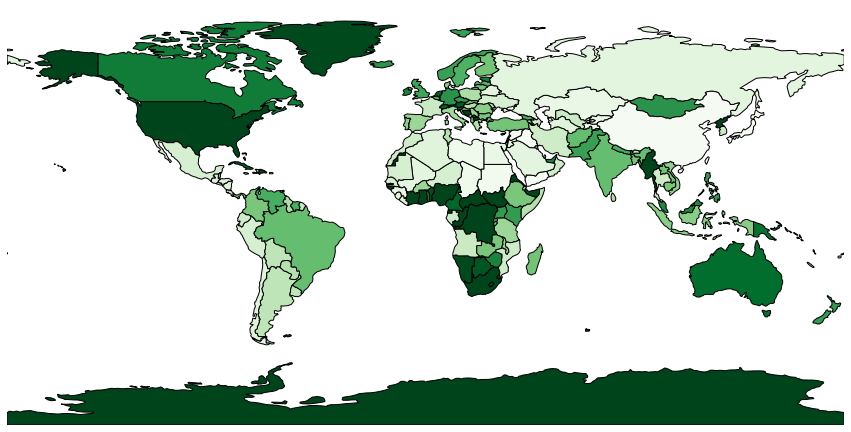

In [73]:
# plot world data
plot_by_geo_map(world, interest_by_geo_world)

In [79]:
# load geo us
us = gpd.read_file('../../data/raw/us_geo/states.shp')

In [75]:
# load interest ratio by us regions
interest_by_geo_us = pd.read_csv('../../data/raw/geoMap_usa.csv')
interest_by_geo_us.dropna(inplace=True)
interest_by_geo_us = interest_by_geo_us.set_index('region')
interest_by_geo_us['search_volume_ratio'] = interest_by_geo_us['search_volume_ratio'].astype(int)

In [81]:
# clean interest_by_geo_us
merged = pd.merge(left=us, right=interest_by_geo_us, how='left', left_on='STATE_NAME', right_on='region')
interest_by_geo_us = merged['search_volume_ratio']

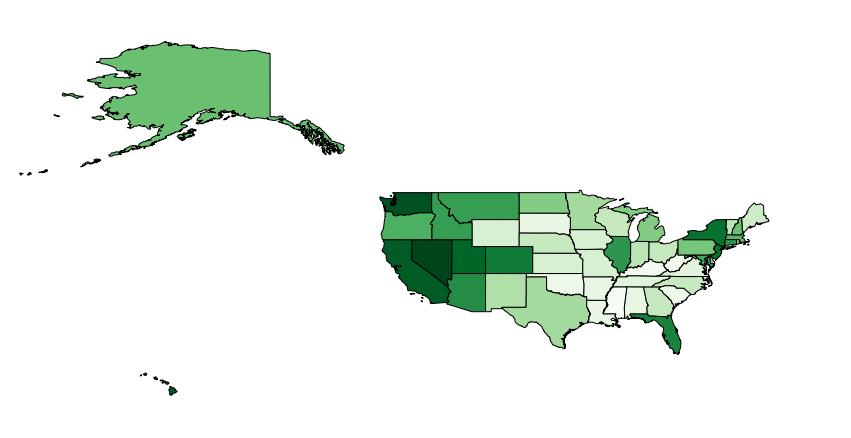

In [82]:
# plot US data
plot_by_geo_map(us, interest_by_geo_us)

### Plot search/price trends

In [119]:
# search ratio data
search_ratio = pd.read_csv('../../data/raw/multiTimeline.csv')
search_ratio = search_ratio.set_index('date')
search_ratio.index = pd.to_datetime(search_ratio.index)
# concatenate price and search ratio
merged = pd.concat([price_data, search_ratio], axis=1, join='inner', sort=True)
# change price format to numeric
merged.Price = merged.Price.str.replace(',', '').astype(float)
# create price ratio column to normalize dataset
merged['price_ratio'] = (merged['Price']/merged['Price'].max())*100


In [139]:
# plot line chart for whole period
def line_chart_bit_exchange_rate_vs_trends(x, search_ratio, price_ratio):
    '''Plots line chart of volume ratio vs price for whole historical period of given data
    :params: data is a list of samples'''
    font = {'fontname':'Arial', 'size':'20'}
    fig = plt.figure(figsize=(30,20))
    plt.plot(x, search_ratio, c='blue', label='Search volume')
    plt.plot(x, price_ratio, c='red', label='Price')
    plt.xlabel('Year', font)
    plt.ylabel('Ratio', font)
    plt.title('Trends google search ratio and price ratio, 2011-2020', font)
    plt.legend(loc='upper left')
    plt.show()

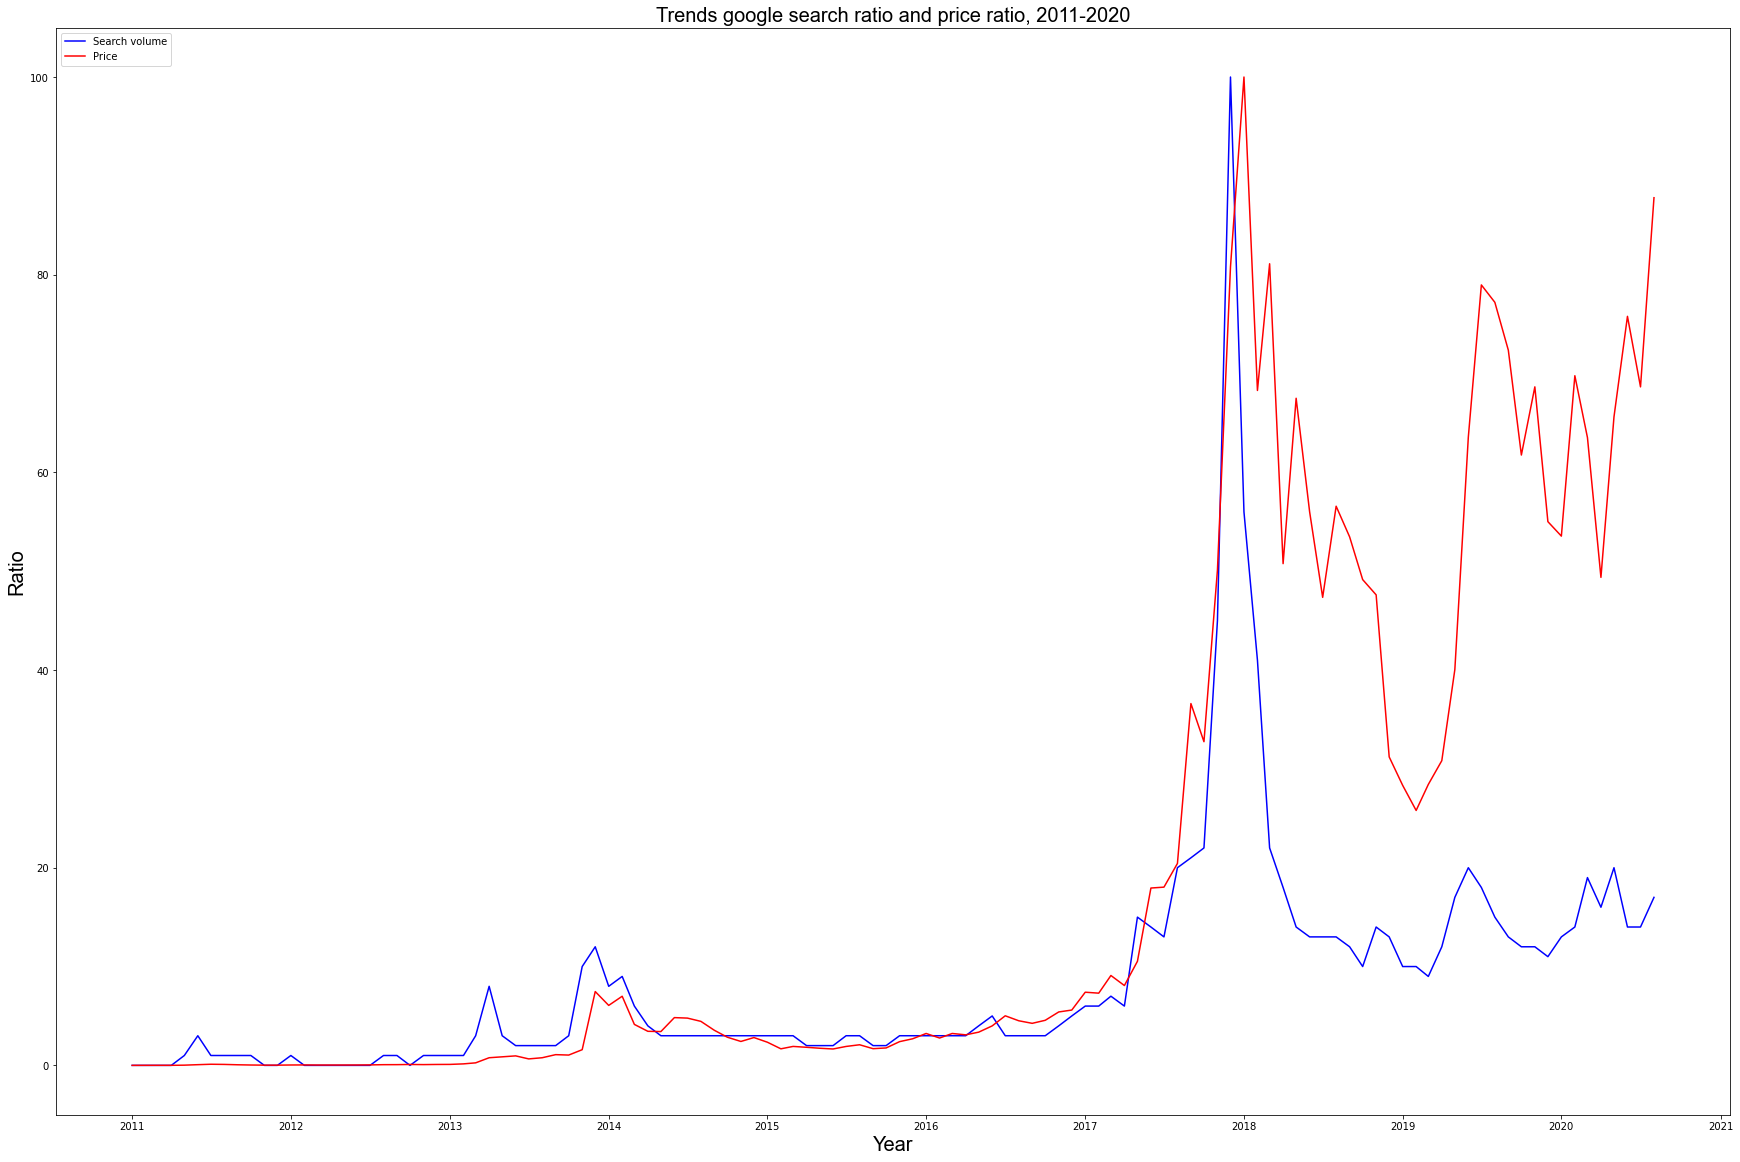

In [140]:
line_chart_bit_exchange_rate_vs_trends(merged.index, merged['volume_ratio'], merged['price_ratio'])

In [10]:
# plot scatter for time series
def scatter_plot_bit_exchange_rate_vs_trends(data):
    data_len = len(data)
    fig = plt.figure(figsize=(15,50))
    for i, d in enumerate(data):
        ax = fig.add_subplot(data_len, 1, i + 1)
        ax.scatter(d['volume_ratio'], d['price'])
        ax.axes.yaxis.set_visible(False)
    plt.show()

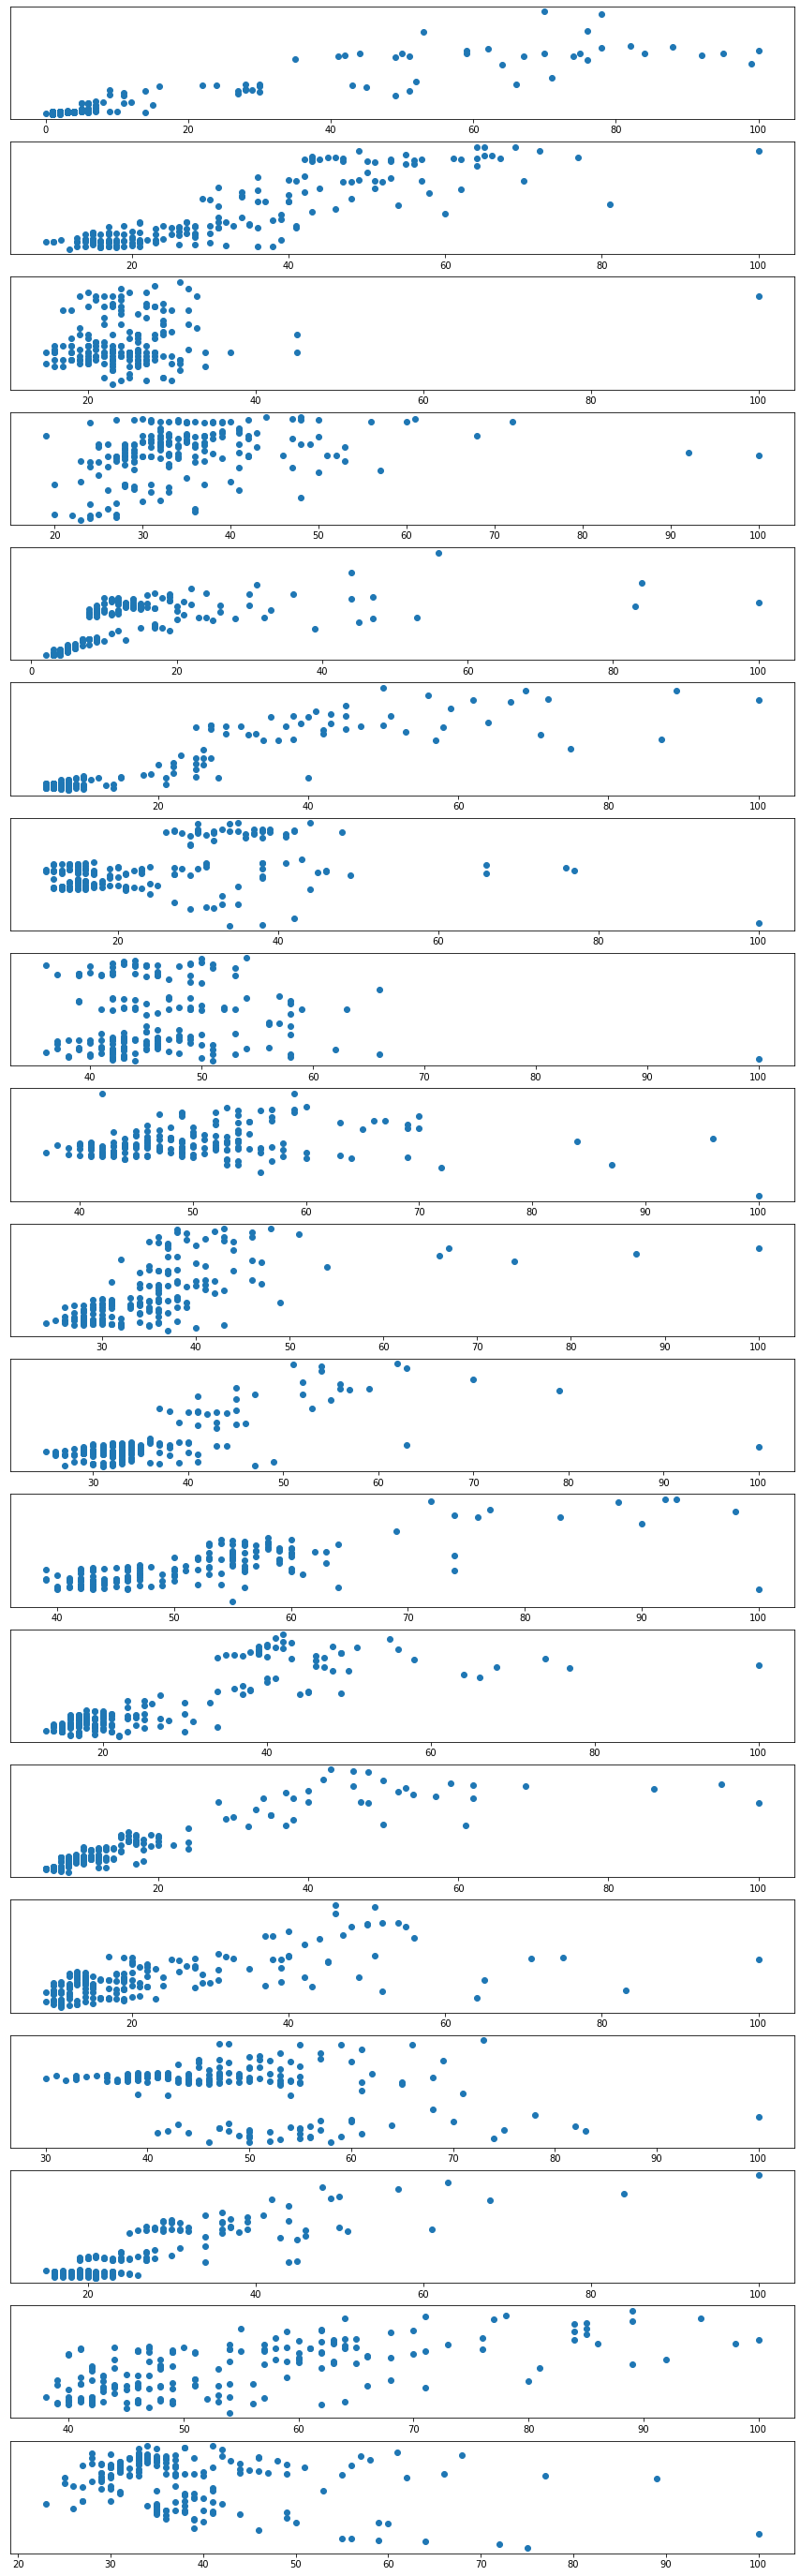

In [11]:
scatter_plot_bit_exchange_rate_vs_trends(data)

In [12]:
def line_chart_bit_exchange_rate_vs_trends(data, price_ratio=False):
    '''Plots line chart of volume ratio vs price
    :params: data is a list of samples'''
    data_len = len(data)
    fig = plt.figure(figsize=(15,50))
    for i, d in enumerate(data):
        ax = fig.add_subplot(data_len, 1, i + 1)
        ax.plot(d.index, d['volume_ratio'], c='blue', label='Volume')
        if price_ratio:
            ax.plot(d.index, d['price_ratio'], c='orange', label='Price')
        else:
            ax.plot(d.index, d['price'], c='orange', label='Price')
        ax.axes.yaxis.set_visible(False)
        ax.legend(loc='upper left')
    plt.show()

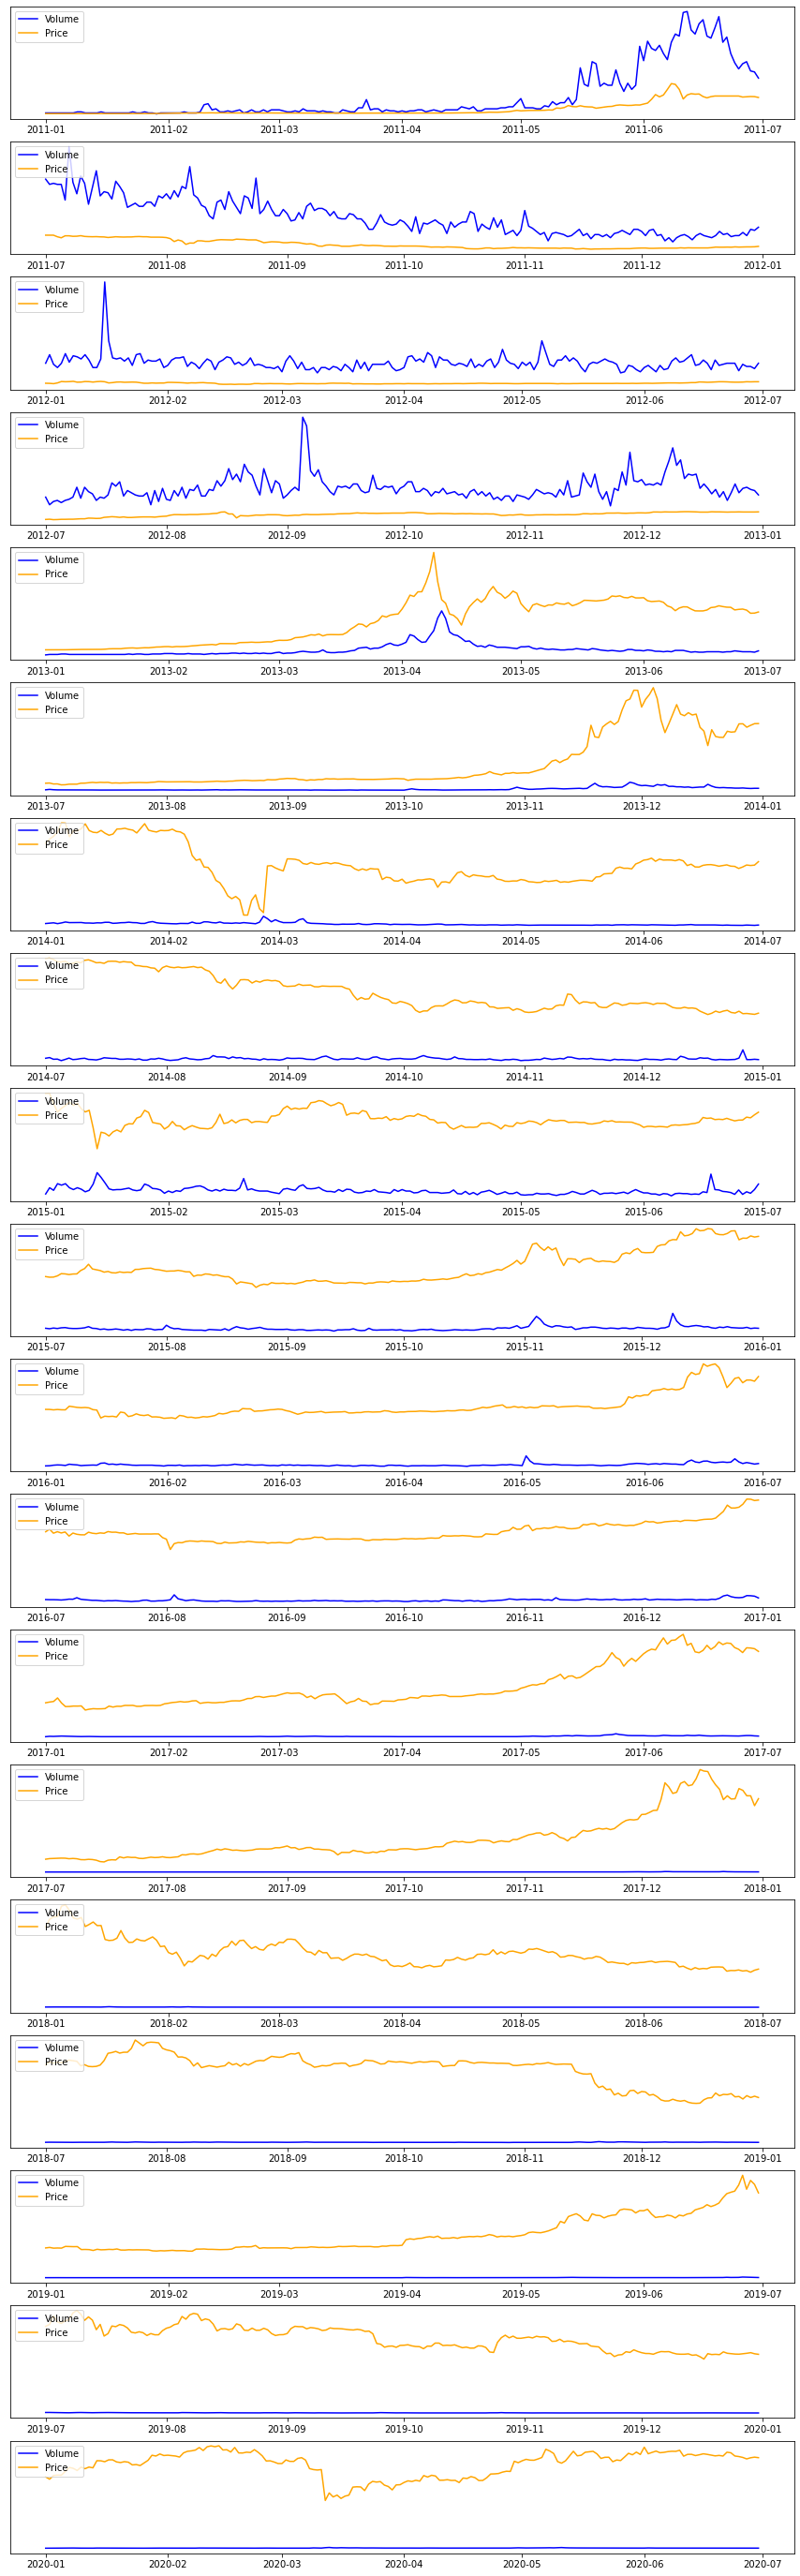

In [13]:
line_chart_bit_exchange_rate_vs_trends(data)

We cannot see patterns here mostly because price of bitcoin started to grow dramatically in 2017 while volume ratio is still represented on scale with maximum point 100. We will handle this issue further.

### Feature engineering

As you can see plot shows that dependencies are not obvious. We will do one step closer to find more relevant insights and create a feature based on google algorithm to build a graph. We will take following steps:
 *  calculate relative price as a ratio of the price volume to the maximum price for a given period of time.
  * scale the values proportionally so the maximum value is 100 for a given period of time.

New ratio allows us to normalize our samples and connect them to each other in order to create a single model.

In [14]:
def get_ratio(current_price, max_price):
    '''Returns ratio current price to the maximum price for a sample
    :params: current price on a given day, max_price for a given period'''
# todo convert to int in the beginning
    ratio = int((current_price/max_price)*100)
    return ratio

# function to create a new feature for a sample
def calculate__current_price_ratio(samples):
    '''Updates a dataset by creating a new ratio for a price to a maximum price for a sample'''
    for sample in samples:
        max_price = sample['price'].max()
        sample['price_ratio'] = sample['price'].apply(get_ratio, args=(max_price,))
    return samples


In [15]:
data = calculate__current_price_ratio(data)

In [16]:
data[0]


,volume_ratio,price,price_ratio
date,,,
2011-01-01,1,0.3,1
2011-01-02,1,0.3,1
2011-01-03,1,0.3,1
2011-01-04,1,0.3,1
2011-01-05,1,0.3,1
...,...,...,...
2011-06-26,49,16.5,55
2011-06-27,51,16.8,56
2011-06-28,42,17.0,57


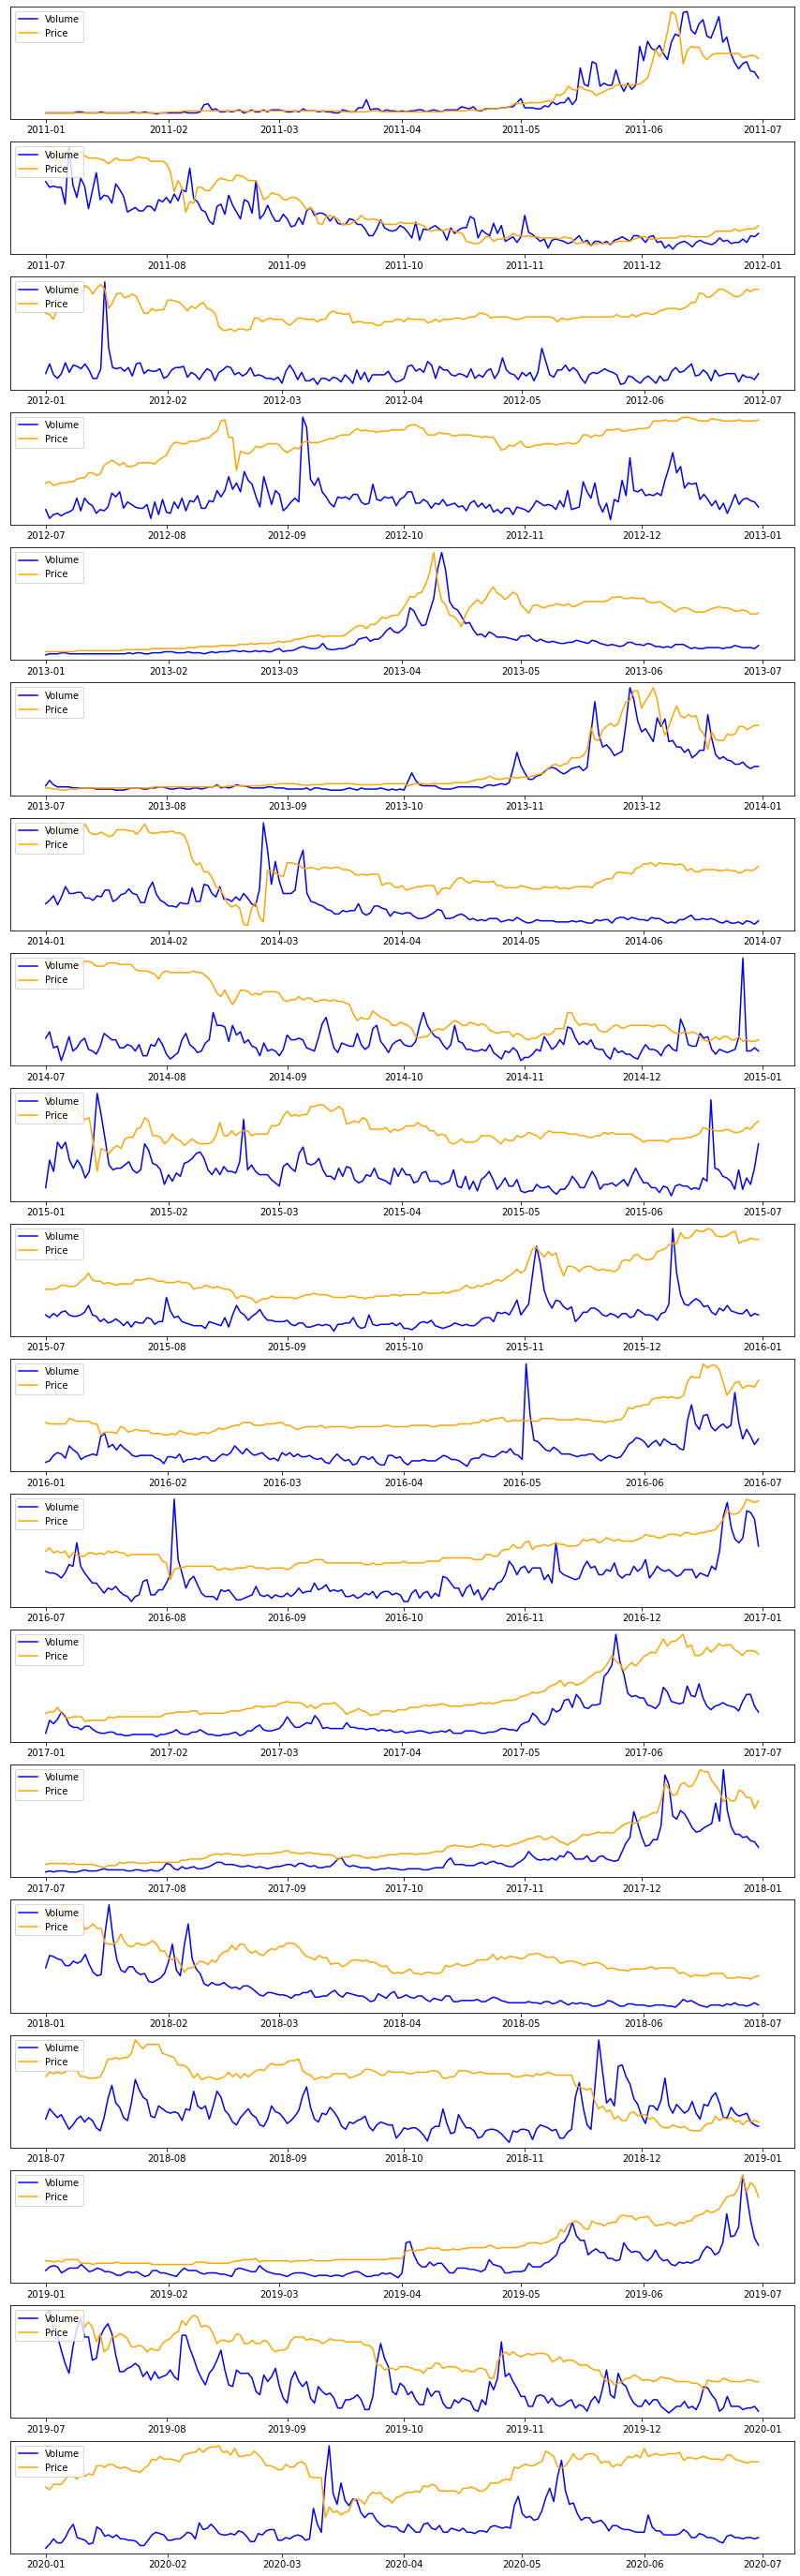

In [17]:
# plot line chart volume_ratio vs price_ratio
line_chart_bit_exchange_rate_vs_trends(data, price_ratio=True)

### Correlation

In [143]:
merged.corr()

,Price,volume_ratio,price_ratio
Price,1.000000,0.700693,1.000000
volume_ratio,0.700693,1.000000,0.700693
price_ratio,1.000000,0.700693,1.000000


The matrix demonstrates us quiet strong correlation between price and search volume.